# Naive Bayes Classifier for Text Classification

Here we use Naive Bayes Classifier for sms spam detection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [3]:
df = df[['v1', 'v2']].rename(columns={'v1': 'Label', 'v2': 'Text'})
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.Label.value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

In [5]:
# Map the labels to numerical values
df['Label'] = df.Label.map({'ham': 0, 'spam': 1})

In [6]:
len(df)

5572

We split the dataset as: training (3572), validation (1000), test (1000).

In [7]:
train_df = df.iloc[:-2000]
val_df = df.iloc[-2000:-1000]
test_df = df.iloc[-1000:]

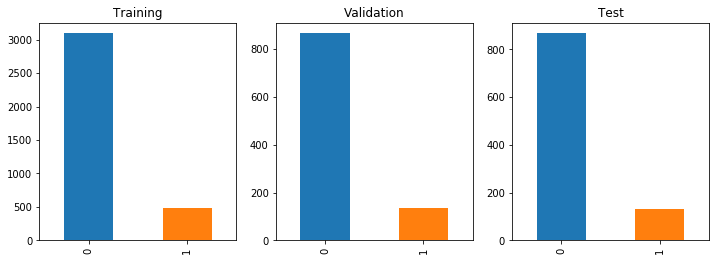

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
train_df.Label.value_counts().plot.bar(ax=axes[0], title='Training')
val_df.Label.value_counts().plot.bar(ax=axes[1], title='Validation')
test_df.Label.value_counts().plot.bar(ax=axes[2], title='Test')

We should probably shuffle the dataset before splitting but it looks like the classes are evenly distributed even when directly splitting. So, we let it be.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [10]:
def report_metrics(actual, preds):
    print('Accuracy score: {}'.format(accuracy_score(actual, preds)))
    print('Precision score: {}'.format(precision_score(actual, preds)))
    print('Recall score: {}'.format(recall_score(actual, preds)))
    print('F1 score: {}'.format(f1_score(actual, preds)))

In [11]:
x_train, y_train = train_df['Text'], train_df['Label']
x_val, y_val = val_df['Text'], val_df['Label']
x_test, y_test = test_df['Text'], test_df['Label']

# 1. Baseline (All hams)

As *Ham* is the more common class, the baseline could be a model that always predicts ham.

In [12]:
preds = np.zeros_like(y_val)
report_metrics(y_val, preds)

Accuracy score: 0.865
Precision score: 0.0
Recall score: 0.0
F1 score: 0.0


/home/yokai/anaconda3/envs/py3k/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yokai/anaconda3/envs/py3k/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# 2. Using Sklearn

## Variation 1: Without removing stop words

In [13]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(x_train)
classifier = MultinomialNB()
classifier.fit(counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
val_counts = vectorizer.transform(x_val)
preds = classifier.predict(val_counts)
report_metrics(y_val, preds)

Accuracy score: 0.987
Precision score: 0.9765625
Recall score: 0.9259259259259259
F1 score: 0.9505703422053232


## Variation 2: Removing Stop words

In [15]:
vectorizer = CountVectorizer(stop_words="english")
counts = vectorizer.fit_transform(x_train)
classifier = MultinomialNB()
classifier.fit(counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
val_counts = vectorizer.transform(x_val)
preds = classifier.predict(val_counts)
report_metrics(y_val, preds)

Accuracy score: 0.986
Precision score: 0.9763779527559056
Recall score: 0.9185185185185185
F1 score: 0.9465648854961832


It looks like not removing stop words results in higher F1 score. Strange, but we go with that.

Also, we don't perform any other tuning thus taking this model as the best one on validation and moving on
to test reporting.

## Final Test Reporting

We train on the full available training set i.e training + validation set.

In [17]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(np.concatenate([x_train, x_val]))
classifier = MultinomialNB()
classifier.fit(counts, np.concatenate([y_train, y_val]))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
test_counts = vectorizer.transform(x_test)
preds = classifier.predict(test_counts)
report_metrics(y_test, preds)

Accuracy score: 0.985
Precision score: 0.9402985074626866
Recall score: 0.9473684210526315
F1 score: 0.9438202247191011


# 3. From Scratch (Sort of)

Here we will build our own Naive Bayes Classifier from "scratch".

We will directly go for the final test. No tuning.

In [19]:
train_full_df = pd.concat([train_df, val_df])

In [20]:
from collections import Counter

### Counts for Ham

In [21]:
ham_texts = train_full_df[train_full_df.Label == 0]['Text']
ham_texts[:5]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: Text, dtype: object

In [22]:
ham_counts = Counter()
for text in ham_texts:
    for word in text.split():
        ham_counts[word.lower()] += 1
ham_counts.most_common(10)

[('i', 1784),
 ('you', 1414),
 ('to', 1271),
 ('the', 918),
 ('a', 863),
 ('u', 717),
 ('and', 710),
 ('in', 644),
 ('my', 611),
 ('is', 592)]

### Counts for Spam

In [23]:
spam_texts = train_full_df[train_full_df.Label == 1]['Text']
spam_texts[:5]

2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: Text, dtype: object

In [24]:
spam_counts = Counter()
for text in spam_texts:
    for word in text.split():
        spam_counts[word.lower()] += 1
spam_counts.most_common(10)

[('to', 559),
 ('a', 299),
 ('call', 272),
 ('your', 204),
 ('you', 203),
 ('the', 165),
 ('for', 159),
 ('free', 149),
 ('or', 149),
 ('2', 140)]

### Calculating Likelihood

Recall that we need two things to compute the *posterior*: the *likelihood* and the *prior*. 
(We don't need to consider the *evidence*).

Let's attempt to define the likehood calculator.

In [25]:
def calculate_likelihood(tokens, counts):
    """Calculates likelihood for given tokens.
    
    Due to independence assumption, it's just the product of the
    individual probabilities.
    """
    total_count = sum(counts.values())
    l = 1.0
    for t in tokens:
        l *= counts[t.lower()] / total_count
    return l

This has two main issues.

First issue: we get very small numbers.

In [26]:
calculate_likelihood(['Free', 'entry'], spam_counts)

1.4602999740832923e-05

Secondly, if one of the tokens weren't in the corpus, everything ends up being zero!

In [27]:
calculate_likelihood(['Free', 'food'], spam_counts)

0.0

To handle these issues, we use... math!

In [28]:
import math

In [29]:
def calculate_log_likelihood(tokens, counts):
    """Calculates log likelihood for given tokens.
    
    Also uses Laplacian smoothing to handle tokens with zero counts.
    
    Note: The product over the probabilities has become sum over log probabilities.
    The denominator is the same for all tokens. We can deduct it at the end for 
    each token. So, len(tokens) number of deductions.
    """
    total_count = sum(counts.values())
    vocab_size = len(counts)
    l = 0.0
    for t in tokens:
        l += math.log(counts[t.lower()] + 1)
    l = l - len(tokens) * math.log(total_count + vocab_size)
    return l

In [30]:
calculate_log_likelihood(['Free', 'entry'], spam_counts)

-11.493576076218668

In [31]:
calculate_log_likelihood(['Free', 'food'], spam_counts)

-14.584618529576984

### Calculating the priors

The priors are the class probabilities (in the training set).

In [32]:
spam_prior = len(spam_texts) / len(train_full_df)
print(spam_prior)
ham_prior = len(ham_texts) / len(train_full_df)
print(ham_prior)

0.1342957130358705
0.8657042869641295


## Bringing it all together

In [33]:
class SpamClassifier:
    def __init__(self, spam_prior, ham_prior, spam_counts, ham_counts):
        self.spam_prior = spam_prior
        self.ham_prior = ham_prior
        self.spam_counts = spam_counts
        self.ham_counts = ham_counts
    
    def predict(self, text):
        spam_posterior = math.exp(calculate_log_likelihood(text.split(), self.spam_counts)) * self.spam_prior
        ham_posterior = math.exp(calculate_log_likelihood(text.split(), self.ham_counts)) * self.ham_prior
        return 1 if spam_posterior > ham_posterior else 0
    

In [34]:
classifier = SpamClassifier(spam_prior, ham_prior, spam_counts, ham_counts)

In [35]:
print(classifier.predict('How are you?'))
print(classifier.predict('Free lunch!'))

0
1


In [36]:
test_preds = [classifier.predict(text) for text in x_test]
report_metrics(y_test, test_preds)

Accuracy score: 0.935
Precision score: 0.6752577319587629
Recall score: 0.9849624060150376
F1 score: 0.8012232415902141


Performs much worse (0.80 F1) than Sklearn's classifier (0.94 F1) but as the accuracy shows, it's better than the baseline (0.93 vs 0.86).